In [1]:
import gc # garbage collector
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder

In [2]:
LISTE_MAJ = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
LISTE_MIN = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
LISTE_NBR = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

BATCH_SIZE = 256
EPOCHS = 10
ADD_NOM = "3_b" + str(BATCH_SIZE) + "_e" + str(EPOCHS)

In [3]:
# shape of the image : 50x50
# number of classes : 3 (majuscules, minuscules, chiffres)

# Dataset_total_test : 2_487_824
# Dataset_total_train : 7_795_632
# Dataset_total_validation : 2_490_976

# Get Data
---

- Récupération des données de la base de données
- formattage des données
- répartition des données

In [4]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données

In [5]:
def fetch_data(nom_collection: str, nbr: int):
    collection = db[nom_collection]  # Nom de la collection
    documents = collection.find()
    print(f"fetch {nom_collection} OK !!!")

    images = []
    labels = []
    types = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            types.append(doc["Type"])
            pbar.update(1) # Mettre à jour la barre de progression
            
    # return np.array(images), np.array(labels, dtype=str)
    return pd.DataFrame({"Labels": labels, "Types": types, "Images": images})

### Récupérations des données de toutes les collections
---

In [6]:
df_maj_test = fetch_data("Dataset_Maj_test", 689_936)
df_maj_test = df_maj_test.sample(frac=1).reset_index(drop=True)
print(df_maj_test.shape)
df_maj_test.head()
# Temps : 41.2s

fetch Dataset_Maj_test OK !!!


Proccessing: 100%|██████████| 689936/689936 [00:40<00:00, 16844.04it/s]


(689936, 3)


,Labels,Types,Images
0,W,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,C,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,E,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,O,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [7]:
df_maj_train = fetch_data("Dataset_Maj_train", 2_405_456)
df_maj_train = df_maj_train.sample(frac=1).reset_index(drop=True)
print(df_maj_train.shape)
df_maj_train.head()
# Temps : 3m 1.7s

fetch Dataset_Maj_train OK !!!


Proccessing: 100%|██████████| 2405456/2405456 [03:00<00:00, 13323.76it/s]


(2405456, 3)


,Labels,Types,Images
0,F,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,D,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,I,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [8]:
df_maj_validation = fetch_data("Dataset_Maj_validation", 692_000)
df_maj_validation = df_maj_validation.sample(frac=1).reset_index(drop=True)
print(df_maj_validation.shape)
df_maj_validation.head()
# Temps : 1m 3.0s

fetch Dataset_Maj_validation OK !!!


Proccessing: 100%|██████████| 692000/692000 [01:02<00:00, 11035.39it/s]


(692000, 3)


,Labels,Types,Images
0,I,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,O,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,Y,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
df_min_test = fetch_data("Dataset_Min_test", 597_728)
df_min_test = df_min_test.sample(frac=1).reset_index(drop=True)
print(df_min_test.shape)
df_min_test.head()
# Temps : 1m 9.1s

fetch Dataset_Min_test OK !!!


Proccessing: 100%|██████████| 597728/597728 [01:08<00:00, 8681.44it/s] 


(597728, 3)


,Labels,Types,Images
0,c,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,e,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,a,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,l,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [10]:
df_min_train = fetch_data("Dataset_Min_train", 1_787_408)
df_min_train = df_min_train.sample(frac=1).reset_index(drop=True)
print(df_min_train.shape)
df_min_train.head()
# Temps : 3m 18.5s 

fetch Dataset_Min_train OK !!!


Proccessing: 100%|██████████| 1787408/1787408 [03:17<00:00, 9041.65it/s] 


(1787408, 3)


,Labels,Types,Images
0,l,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,r,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,l,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,l,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,j,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
df_min_validation = fetch_data("Dataset_Min_validation", 597_984)
df_min_validation = df_min_validation.sample(frac=1).reset_index(drop=True)
print(df_min_validation.shape)
df_min_validation.head()
# Temps : 1m 36.4s

fetch Dataset_Min_validation OK !!!


Proccessing: 100%|██████████| 597984/597984 [01:36<00:00, 6223.29it/s]


(597984, 3)


,Labels,Types,Images
0,e,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,x,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,h,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,l,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,r,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
df_nbr_test = fetch_data("Dataset_Nbr_test", 1_200_160)
df_nbr_test = df_nbr_test.sample(frac=1).reset_index(drop=True)
print(df_nbr_test.shape)
df_nbr_test.head()
# Temps : 3m 3.3s

fetch Dataset_Nbr_test OK !!!


Proccessing: 100%|██████████| 1200160/1200160 [03:02<00:00, 6567.17it/s] 


(1200160, 3)


,Labels,Types,Images
0,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,1,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [13]:
df_nbr_train = fetch_data("Dataset_Nbr_train", 3_602_768)
df_nbr_train = df_nbr_train.sample(frac=1).reset_index(drop=True)
print(df_nbr_train.shape)
df_nbr_train.head()
# Temps : 8m 39.0s

fetch Dataset_Nbr_train OK !!!


Proccessing: 100%|██████████| 3602768/3602768 [08:37<00:00, 6966.02it/s]


(3602768, 3)


,Labels,Types,Images
0,5,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,9,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,5,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [14]:
df_nbr_validation = fetch_data("Dataset_Nbr_validation", 1_200_992)
df_nbr_validation = df_nbr_validation.sample(frac=1).reset_index(drop=True)
print(df_nbr_validation.shape)
df_nbr_validation.head()
# Temps : 6m 30.4s

fetch Dataset_Nbr_validation OK !!!


Proccessing: 100%|██████████| 1200992/1200992 [06:29<00:00, 3080.61it/s]


(1200992, 3)


,Labels,Types,Images
0,1,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,3,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,5,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,6,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


### Concaténation des df des collections
---

Concaténation des df des collections pour générer les df totaux

In [15]:
df_total_test = pd.concat([df_maj_test, df_min_test, df_nbr_test], ignore_index=True)
df_total_test = df_total_test.sample(frac=1).reset_index(drop=True)
print(df_total_test.shape) # (1_485_153, 3)
df_total_test.head()
# Temps : 

(2487824, 3)


,Labels,Types,Images
0,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,S,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [16]:
df_total_train = pd.concat([df_maj_train, df_min_train, df_nbr_train], ignore_index=True)
df_total_train = df_total_train.sample(frac=1).reset_index(drop=True)
print(df_total_train.shape) # (7_795_632, 3)
df_total_train.head()
# Temps : 

(7795632, 3)


,Labels,Types,Images
0,P,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,u,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,8,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,0,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [17]:
df_total_validation = pd.concat([df_maj_validation, df_min_validation, df_nbr_validation], ignore_index=True)
df_total_validation = df_total_validation.sample(frac=1).reset_index(drop=True)
print(df_total_validation.shape) # (1_445_672, 3)
df_total_validation.head()
# Temps : 

(2490976, 3)


,Labels,Types,Images
0,O,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,0,Nbr,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,r,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,q,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


##### Suppression
---

Suppression des données pour l'apprentissage de 'Get types' plus utilisées

In [ ]:
del df_maj_test, df_maj_train, df_maj_validation, df_min_test, df_min_train, df_min_validation, df_nbr_test, df_nbr_train, df_nbr_validation
gc.collect()

### Données pour apprentissage du NN 'Get types'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get type' qui permettra de classé les images selon trois catégories :

- Majuscule
- Minuscule
- Nombre

In [ ]:
X_train_types = np.array(df_total_train["Images"].tolist())
# Temps : 

In [ ]:
y_train_types = np.array(df_total_train["Types"].tolist())
# Temps : 

In [ ]:
X_test_types = np.array(df_total_test["Images"].tolist())
# Temps : 

In [ ]:
y_test_types = np.array(df_total_test["Types"].tolist())
# Temps : 

In [ ]:
X_validation_types = np.array(df_total_validation["Images"].tolist())
# Temps : 

In [18]:
y_validation_types = np.array(df_total_validation["Types"].tolist())
# Temps : 23m 9.7s

In [19]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_types = LabelEncoder()

y_train_types_2 = label_encoder_types.fit_transform(y_train_types)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_types_2 = label_encoder_types.transform(y_test_types)
y_validation_types_2 = label_encoder_types.transform(y_validation_types)

In [20]:
# Correspondance indices ↔ labels
correspondance_types = dict(enumerate(label_encoder_types.classes_))
print(correspondance_types)

# Liste des labels
labels_types = list(correspondance_types.values())
print(labels_types)

{0: 'Maj', 1: 'Min', 2: 'Nbr'}
['Maj', 'Min', 'Nbr']


In [21]:
# Afficher quelques informations
print(f"Taille de X_train_types: {X_train_types.shape}, y_train_types: {y_train_types.shape}, y_train_types_2: {y_train_types_2.shape}")
print(f"Taille de X_test_types: {X_test_types.shape}, y_test_types: {y_test_types.shape}, y_test_types_2: {y_test_types_2.shape}")
print(f"Taille de X_validation_types: {X_validation_types.shape}, y_validation_types: {y_validation_types.shape}, y_validation_types_2: {y_validation_types_2.shape}")

Taille de X_train_types: (7795632, 625), y_train_types: (7795632,), y_train_types_2: (7795632,)
Taille de X_test_types: (2487824, 625), y_test_types: (2487824,), y_test_types_2: (2487824,)
Taille de X_validation_types: (2490976, 625), y_validation_types: (2490976,), y_validation_types_2: (2490976,)


##### Suppression
---

Suppression des données pour l'apprentissage de 'Get types' plus utilisées

In [22]:
del df_total_test, df_total_train, df_total_validation
gc.collect()  # Force la collecte des objets non utilisés

0

# Get Type (NN)
---

Modèle ...

In [45]:
# Reseau de neurones
model_get_type = keras.Sequential([
    keras.layers.Input((625,)), # input layer : 625 neurones (25x25 pixels)
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax') # output layer : 3 neurones (Maj, Min, Nbr) -> softmax : sortie à 3 classes
])

model_get_type.compile(
    optimizer='adam', # optimizer : Adam avec learning rate de 0.0001
    loss='sparse_categorical_crossentropy', # loss : sparse_categorical_crossentropy pour la classification
    metrics=['accuracy'] # metrics : accuracy pour évaluer la performance du modèle
)

In [ ]:
model_get_type.fit(
    X_train_types, 
    y_train_types_2, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(
        X_validation_types, 
        y_validation_types_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.8618
# loss : 0.3311
# Temps : 16m 33.5s

# Batch 64
# accuracy : 0.8644
# loss : 0.3228
# Temps : 8m 41s

# Batch 128
# accuracy : 0.8654
# loss : 0.3209
# Temps : 4m 35.4s

# Batch 256
# accuracy : 0.8644
# loss : 0.3220
# Temps : 2m 46.5s

In [39]:
test_loss_type, test_acc_type = model_get_type.evaluate(X_test_types, y_test_types_2)
print(f"Test accuracy : {test_acc_type}") # Test accuracy : 
print(f"Test loss : {test_loss_type}") # Test loss : 
# Temps : 8.3s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8427 - loss: 0.4143
Test accuracy : 0.8420531153678894
Test loss : 0.4206249415874481


In [40]:
# Sauvegarder le modèle
model_get_type.save("../models/Get_type_v" + ADD_NOM + ".keras")  # Format HDF5 (.h5)

In [41]:
y_predicted_types = model_get_type.predict(X_test_types)
y_predicted_types[1]
# Temps : 7.2s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step


array([1.2727101e-06, 9.9999869e-01, 1.3928408e-11], dtype=float32)

In [42]:
np.argmax(y_predicted_types[1])

1

In [43]:
# y_predicted_labels1 = np.array([correspondance_types[np.argmax(i)] for i in y_predicted_types])
y_predicted_labels_types = [np.argmax(i) for i in y_predicted_types]
y_predicted_labels_types[:5]

[2, 1, 2, 2, 1]

In [44]:
y_test_types_2[:5]

array([2, 1, 2, 2, 1])

Text(95.72222222222221, 0.5, 'Truth')

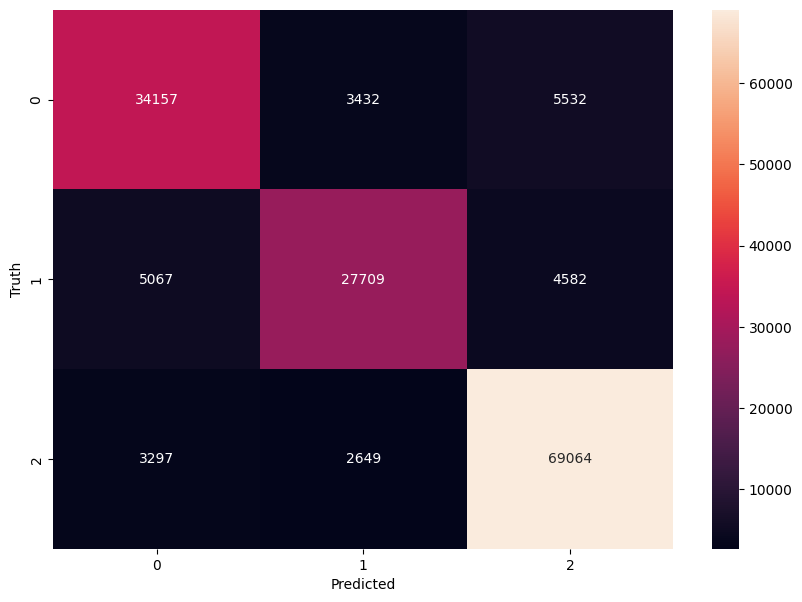

In [45]:
# Matrice de confusion
cm_types = tf.math.confusion_matrix(labels=y_test_types_2, predictions=y_predicted_labels_types)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_types, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')